In [2]:
import os
import pandas as pd
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()

In [3]:
DATA_PATH = os.path.join(
    "..",
    "..",
    "..",
    "..",
    "data",
    "frameworks_data",
    "development_cca",
    "cca_deep_projects_with_translations_v0.2.csv",
)


def flatten(t):
    """
    flatten a list of lists.
    """
    return [item for sublist in t for item in sublist]


cca_data = pd.read_csv(
    DATA_PATH,
    usecols=[
        "id",
        "en",
        "lead_id",
        "created_at",
        "project_id",
        "title",
        "sectors",
        "2dpillars",
        "2dsubpillars",
        "1dpillars",
        "1dsubpillars",
        "geolocation",
        "specific needs groups",
        "demographic groups",
    ],
    #compression='gzip'
).rename(
    columns={
        "1dpillars": "pillars_1d",
        "2dpillars": "pillars_2d",
        "1dsubpillars": "subpillars_1d",
        "2dsubpillars": "subpillars_2d",
        "id": 'entry_id',
        'created_at': 'creation_year'
    }
)

cca_data["creation_year"] = pd.to_datetime(cca_data["creation_year"]).apply(lambda x: x.year)


for col in [
    "sectors",
    "pillars_2d",
    "subpillars_2d",
    "pillars_1d",
    "subpillars_1d",
    "geolocation",
    "specific needs groups",
    "demographic groups",
]:
    if 'pillar' not in col:
        cca_data[col] = cca_data[col].apply(lambda x: list(set(literal_eval(x))))
    else:    
        cca_data[col] = cca_data[col].apply(literal_eval)

cca_data["subpillars_2d"] = cca_data.apply(
    lambda x: [
        f"{x['pillars_2d'][i]}->{x['subpillars_2d'][i]}"
        for i in range(len(x["subpillars_2d"]))
    ],
    axis=1,
)
cca_data["subpillars_1d"] = cca_data.apply(
    lambda x: [
        f"{x['pillars_1d'][i]}->{x['subpillars_1d'][i]}"
        for i in range(len(x["subpillars_1d"]))
    ],
    axis=1,
)

cca_data["subpillars"] = cca_data.apply(
    lambda x: x["subpillars_1d"] + x["subpillars_2d"], axis=1
)

cca_data["pillars"] = cca_data.apply(
    lambda x: x["pillars_1d"] + x["pillars_2d"], axis=1
)

pillars_list = list(set(flatten(cca_data["pillars"])))

for pillar in pillars_list:
    cca_data[pillar] = cca_data["subpillars"].apply(
        lambda x: [item.split('->')[1] for item in x if pillar.lower() in item.lower()]
    )

"""cca_data = cca_data.drop(
    columns=[
        "pillars_2d",
        "subpillars_2d",
        "pillars_1d",
        "subpillars_1d",
        "pillars",
        "subpillars",
    ]
)"""


'cca_data = cca_data.drop(\n    columns=[\n        "pillars_2d",\n        "subpillars_2d",\n        "pillars_1d",\n        "subpillars_1d",\n        "pillars",\n        "subpillars",\n    ]\n)'

In [4]:
projects_list = cca_data.title.unique().tolist()
projects_list

['CCA/DEEP Central African Republic',
 'CCA/DEEP Ghana',
 'CCA/DEEP Somalia',
 'CCA/DEEP Philippines',
 'CCA/DEEP Ukraine',
 'CCA/DEEP Namibia']

In [5]:
for proj in projects_list:
    df_one_proj = cca_data[cca_data.title==proj]
    print(proj, df_one_proj.creation_year.unique())

CCA/DEEP Central African Republic [2021]
CCA/DEEP Ghana [2021]
CCA/DEEP Somalia [2021]
CCA/DEEP Philippines [2022]
CCA/DEEP Ukraine [2022]
CCA/DEEP Namibia [2022]


In [6]:
geo_mapping_df = pd.read_csv('../../../../data/frameworks_data/per_proj_data/geoarea_v0.1.csv').rename(
    columns={"id": "area_id"}
)

cca_locations = geo_mapping_df[geo_mapping_df['area_id'].isin(list(set(flatten(cca_data['geolocation']))))]

geo_mapper_dict = {x['area_id']: x['title'] for _, x in cca_locations.iterrows()}
mappable_ids = list(geo_mapper_dict.keys())

cca_data['geolocation'] = cca_data['geolocation'].apply(
    lambda x: [geo_mapper_dict[item] for item in x if item in mappable_ids]
)

In [6]:
"""translated_data = pd.concat([
    pd.read_excel('tmp_translated_data/en_part2.xlsx'),
    pd.read_excel('tmp_translated_data/en_part1.xlsx'),
    pd.read_excel('tmp_translated_data/fr.xlsx')
])

cca_original_data = pd.read_csv(
    DATA_PATH
)
cca_original_data["original_language"] = cca_data.excerpt.progress_apply(
    lambda x: model.predict(str(x).replace("\n", ""))[0][0][-2:]
)

cca_with_translated = pd.merge(
    right=cca_original_data.drop(columns=['excerpt']),
    left=translated_data,
    on='entry_id'
)

cca_with_translated.to_csv('tmp_translated_data/cca_deep_projects_with_translations.csv.gz', index=None, compression='gzip')"""

'translated_data = pd.concat([\n    pd.read_excel(\'tmp_translated_data/en_part2.xlsx\'),\n    pd.read_excel(\'tmp_translated_data/en_part1.xlsx\'),\n    pd.read_excel(\'tmp_translated_data/fr.xlsx\')\n])\n\ncca_original_data = pd.read_csv(\n    DATA_PATH\n)\ncca_original_data["original_language"] = cca_data.excerpt.progress_apply(\n    lambda x: model.predict(str(x).replace("\n", ""))[0][0][-2:]\n)\n\ncca_with_translated = pd.merge(\n    right=cca_original_data.drop(columns=[\'excerpt\']),\n    left=translated_data,\n    on=\'entry_id\'\n)\n\ncca_with_translated.to_csv(\'tmp_translated_data/cca_deep_projects_with_translations.csv.gz\', index=None, compression=\'gzip\')'

In [7]:
#sns.histplot(y=flatten(cca_data['demographic groups']))

In [7]:
demographic_groups_age_mapper = {
 'Adult (25 to 59 years)': 'age->Adult (25 to 59 years)',
 'Adult Male (25 to 59 years)': 'age->Adult (25 to 59 years)',
 'Adult female (25-59 years)': 'age->Adult (25 to 59 years)',
 'Children (0-4 years old)': 'age->Infants (0-4 years old)',
 'Children (5 to 17 years old)': 'age->Children (5 to 17 years old)',
 'Children (< 18 years)': 'age->Children (5 to 17 years old)',
 'Children Female (< 18 years)': 'age->Children (5 to 17 years old)',
 'Children Male (< 18 years)': 'age->Children (5 to 17 years old)',
 'Infants (0-2 years old)': 'age->Infants (0-4 years old)',
 'Older Persons (60+ years)': 'age->Older Persons (60+ years)',
 'Older Persons Female (60+ years)': 'age->Older Persons (60+ years)',
 'Older Persons Male (60+ years)': 'age->Older Persons (60+ years)',
 'Youth (18-24 years)': 'age->Youth (18-24 years)',
 'Youth Female (18-24 years)': 'age->Youth (18-24 years)',
 'Youth Male (18-24 years)': 'age->Youth (18-24 years)'
}

demographic_groups_gender_mapper = {
 'Adult Male (25 to 59 years)': 'gender->Female',
 'Adult female (25-59 years)': 'gender->Male',
 'Children Male (< 18 years)': 'gender->Male',
 'Older Persons Female (60+ years)': 'gender->Female',
 'Older Persons Male (60+ years)': 'gender->Male',
 'Youth Female (18-24 years)': 'gender->Female',
 'Youth Male (18-24 years)': 'gender->Male'
}
mappable_groups = list(demographic_groups_gender_mapper.keys())

cca_data['demographic groups'] = cca_data['demographic groups'].apply(
    lambda x: [demographic_groups_age_mapper[item] for item in x] + [demographic_groups_gender_mapper[item] for item in x if item in mappable_groups]
)


In [8]:
list(set(list(demographic_groups_age_mapper.values())))

['age->Children (5 to 17 years old)',
 'age->Older Persons (60+ years)',
 'age->Infants (0-4 years old)',
 'age->Youth (18-24 years)',
 'age->Adult (25 to 59 years)']

In [9]:
cca_data.head(2)

,entry_id,creation_year,en,lead_id,project_id,title,sectors,pillars_2d,subpillars_2d,pillars_1d,...,geolocation,specific needs groups,demographic groups,subpillars,pillars,Progress towards 2030 Agenda,Risks,Stakeholder/ Partnerships,High Level tags,COVID-19 Impact
0,408446,2021,A different understanding of social protection...,61304,2728,CCA/DEEP Central African Republic,[Prosperity],"[Progress towards 2030 Agenda, Progress toward...",[Progress towards 2030 Agenda->National Capaci...,[],...,[Central African Republic],[],[],[Progress towards 2030 Agenda->National Capaci...,"[Progress towards 2030 Agenda, Progress toward...","[National Capacities, Challenges & Barriers]",[],[],[],[]
1,409309,2021,The conduct of peace efforts by women. Many NG...,61751,2728,CCA/DEEP Central African Republic,[Peace],[Progress towards 2030 Agenda],[Progress towards 2030 Agenda->Challenges & Ba...,[High Level tags],...,[Central African Republic],[],[],[High Level tags->Challenges / Opportunities t...,"[High Level tags, Progress towards 2030 Agenda]",[Challenges & Barriers],[],[],[Challenges / Opportunities towards 2030 Agenda],[]


In [10]:
df_ghana = cca_data[cca_data.title=='CCA/DEEP Ghana']
df_somalia = cca_data[cca_data.title=='CCA/DEEP Somalia']
df_CAR = cca_data[cca_data.title=='CCA/DEEP Central African Republic']
df_philippines = cca_data[cca_data.title=='CCA/DEEP Philippines']
df_ukraine = cca_data[cca_data.title=='CCA/DEEP Ukraine']
df_namibia = cca_data[cca_data.title=='CCA/DEEP Namibia']

In [16]:
df_ghana.rename(columns={'en': 'excerpt'}).to_csv('UNDCO data/df_ghana.csv', index=None)
df_somalia.rename(columns={'en': 'excerpt'}).to_csv('UNDCO data/df_somalia.csv', index=None)
df_CAR.rename(columns={'en': 'excerpt'}).to_csv('UNDCO data/df_CAR.csv', index=None)
df_philippines.rename(columns={'en': 'excerpt'}).to_csv('UNDCO data/df_philippines.csv', index=None)
df_ukraine.rename(columns={'en': 'excerpt'}).to_csv('UNDCO data/df_ukraine.csv', index=None)
df_namibia.rename(columns={'en': 'excerpt'}).to_csv('UNDCO data/df_namibia.csv', index=None)

In [17]:
treated_columns = [
    "sectors",
    "subpillars_2d",
    "High Level tags",
    "demographic groups",
    "specific needs groups",
]
len(treated_columns)

5

In [18]:
proj_countries = ['CAR', 'philippines', 'ukraine', 'namibia', 'somalia', 'ghana']
data_as_dict = {one_proj_country: pd.read_csv(f'UNDCO data/df_{one_proj_country}.csv') for one_proj_country in proj_countries}

In [19]:
from utils import get_barplots

In [20]:
df_one_project.columns

Index(['entry_id', 'excerpt', 'lead_id', 'project_id', 'title', 'sectors',
       'geolocation', 'specific needs groups', 'demographic groups',
       'COVID-19 Impact', 'High Level tags', 'Progress towards 2030 Agenda',
       'Risks', 'Stakeholder/ Partnerships'],
      dtype='object')

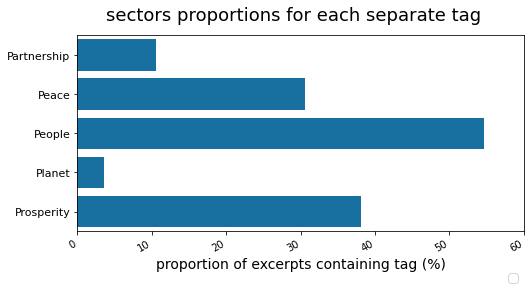

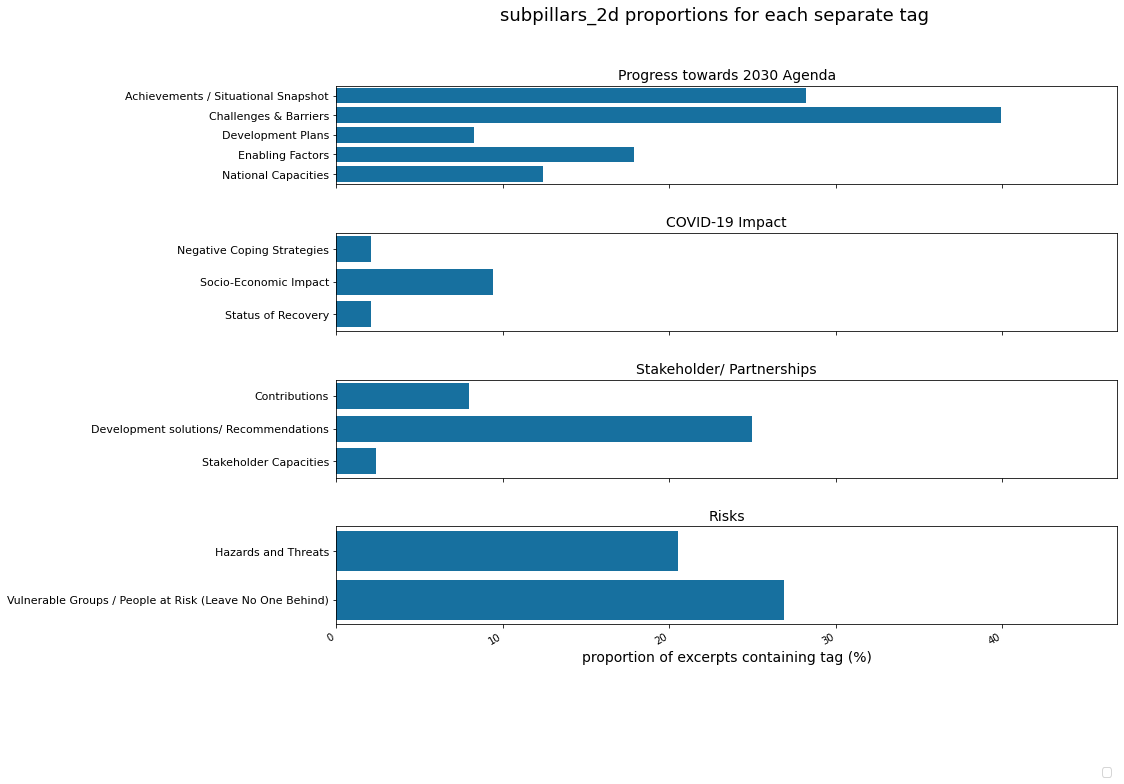

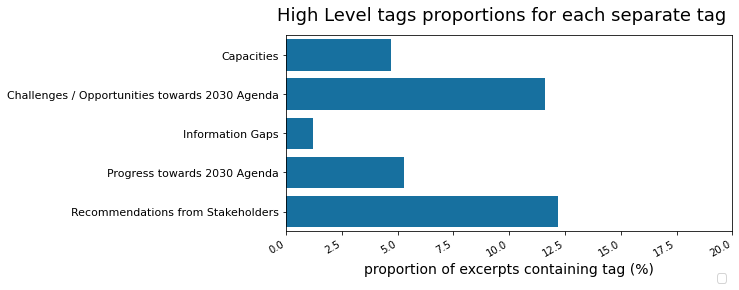

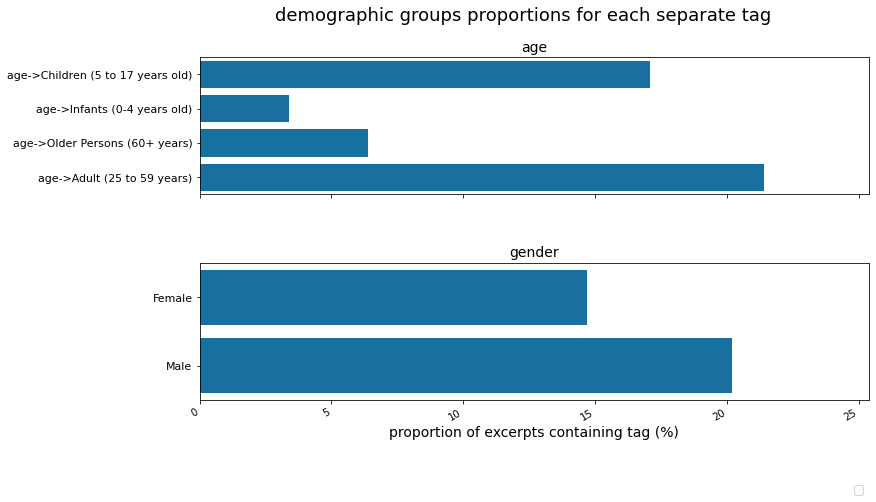

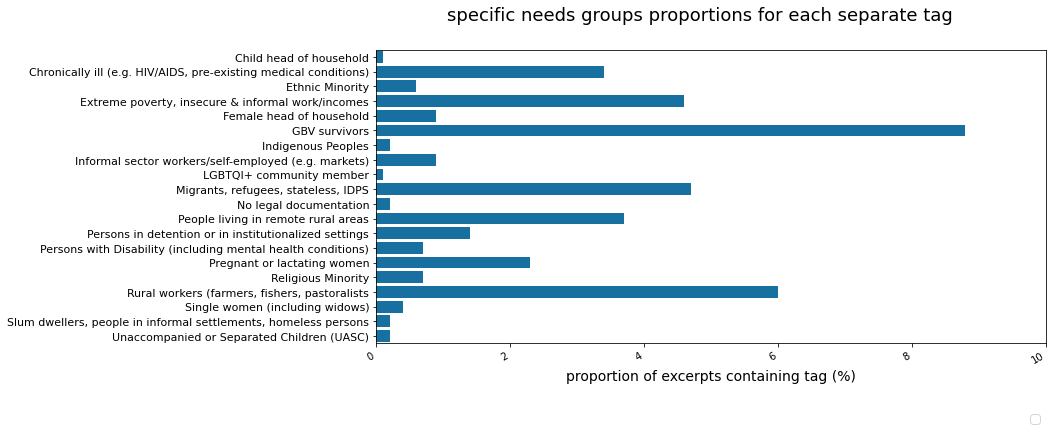

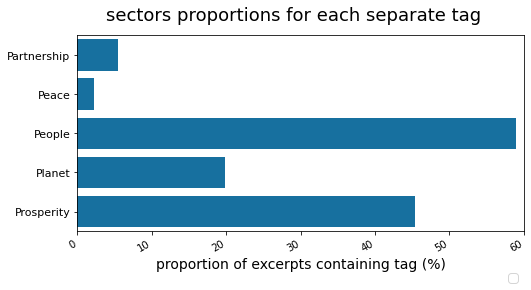

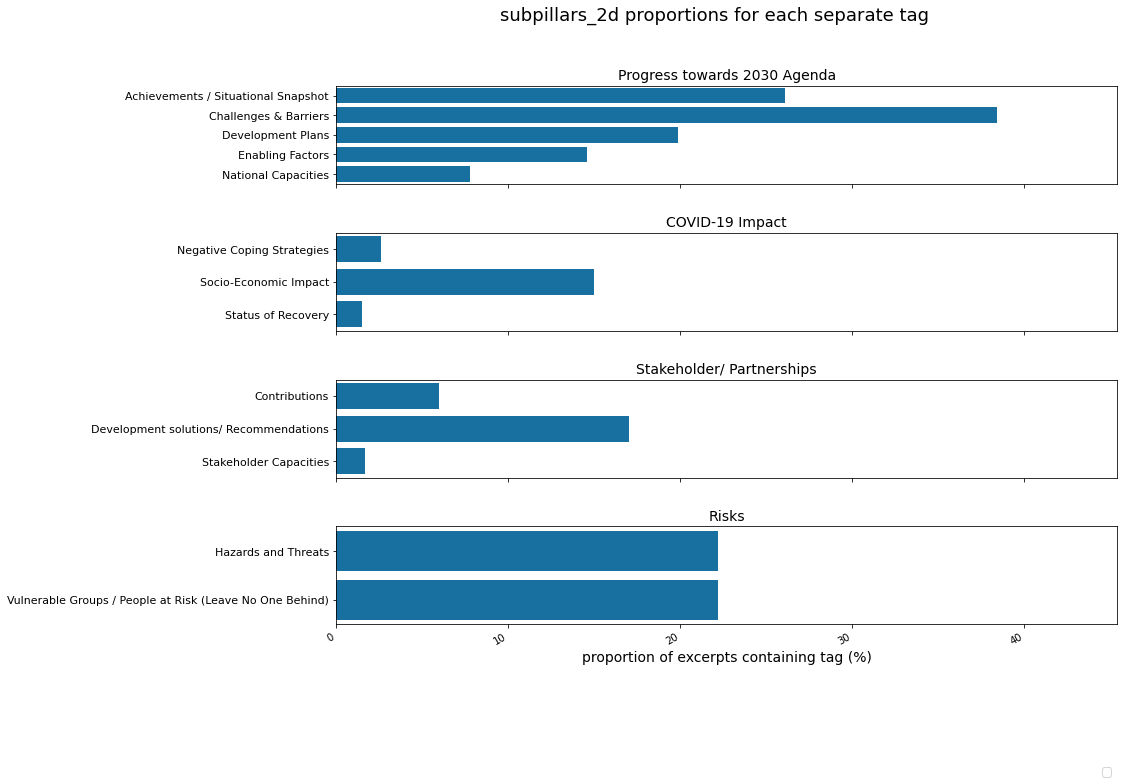

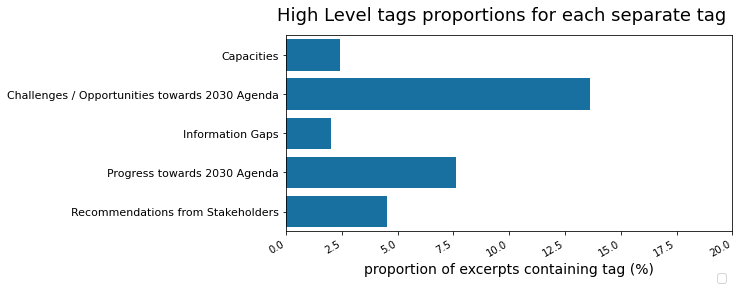

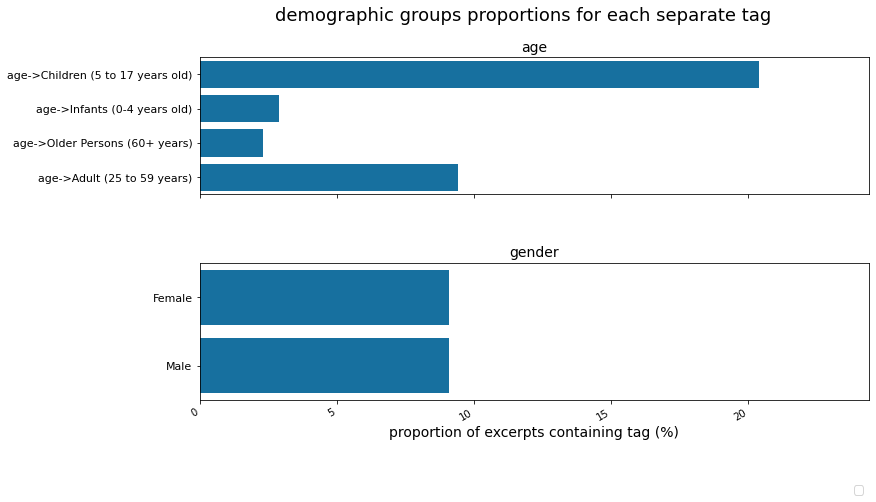

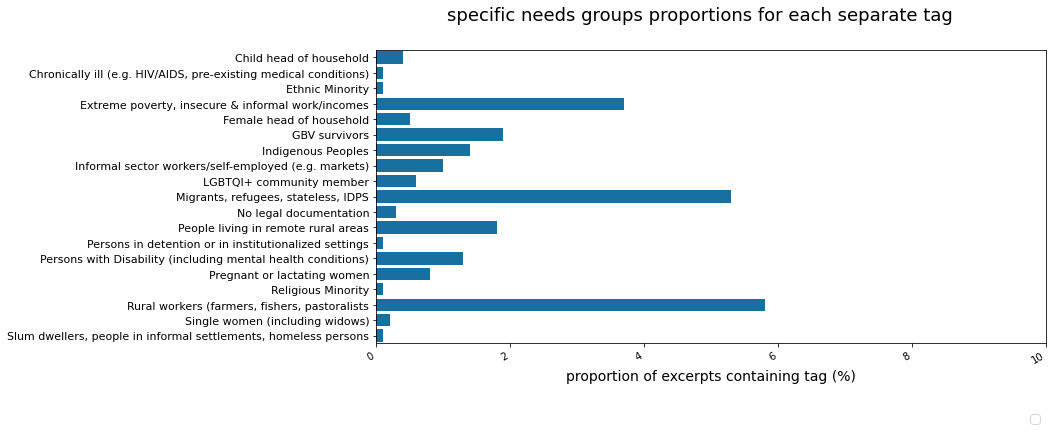

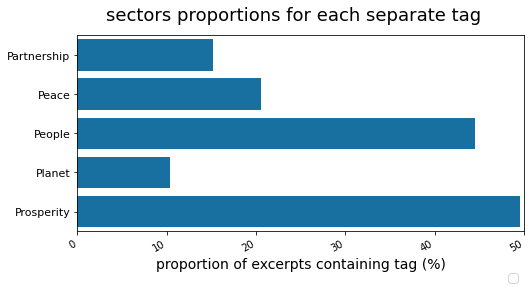

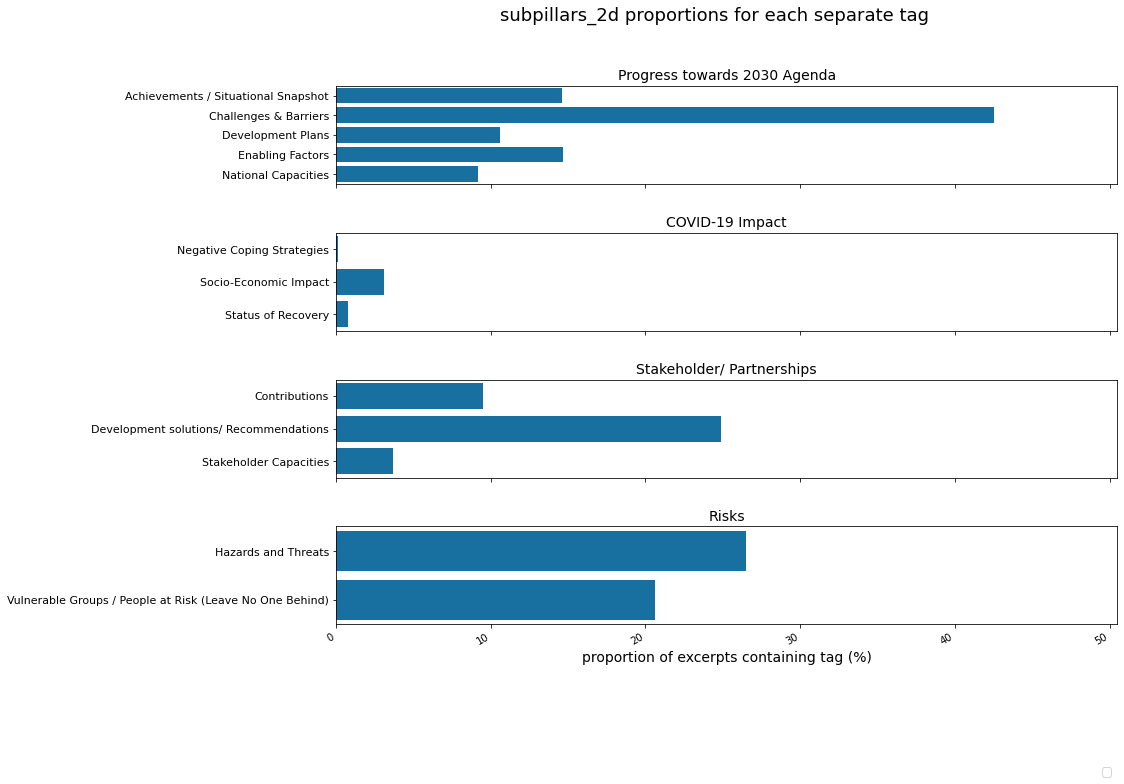

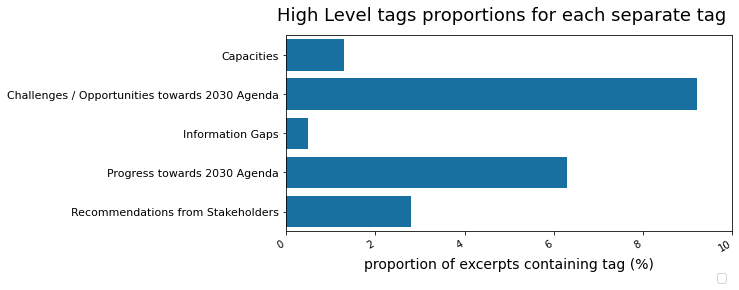

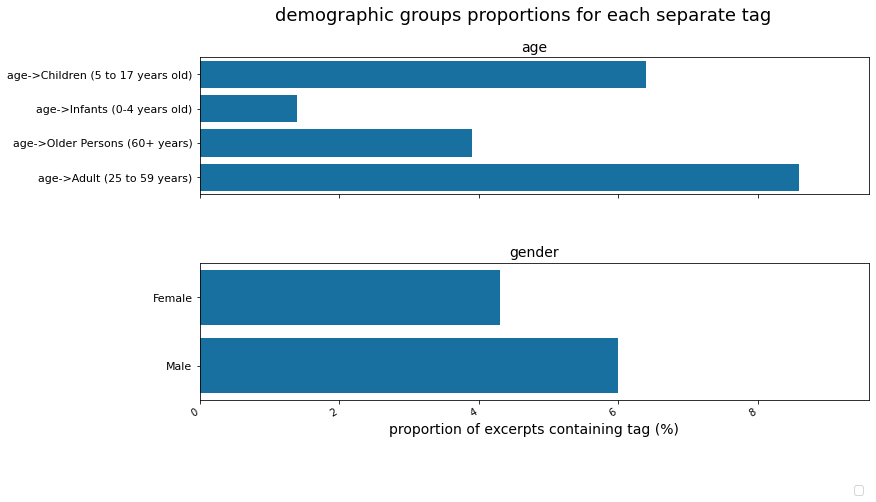

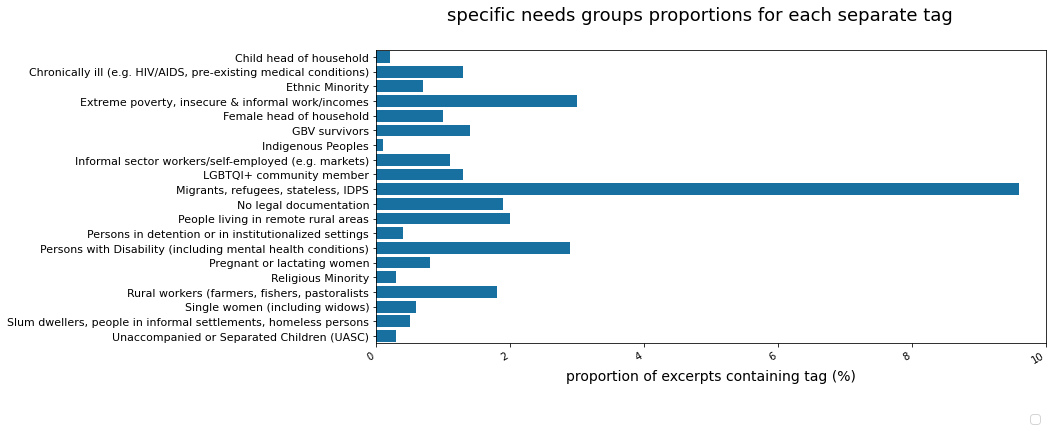

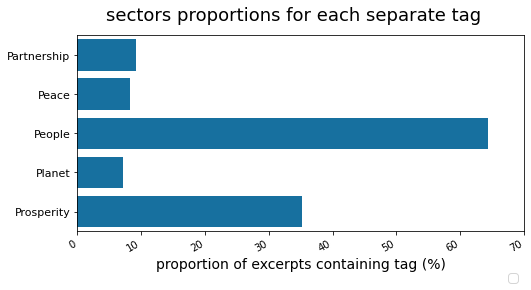

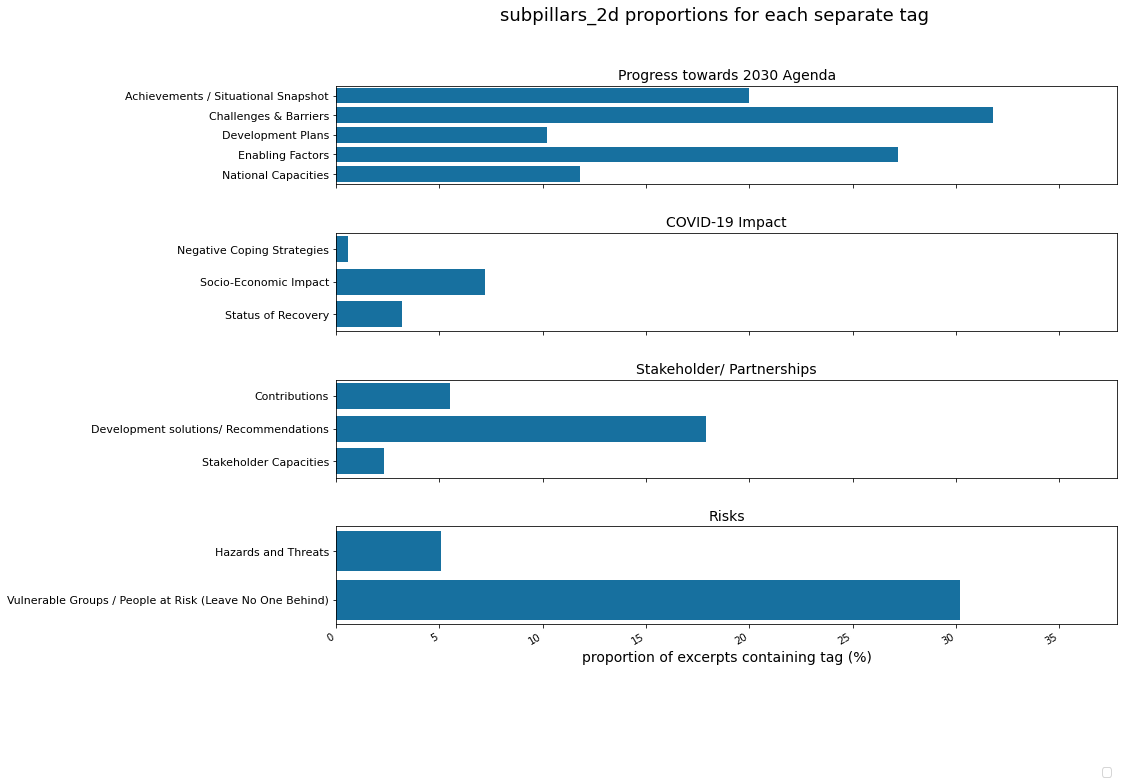

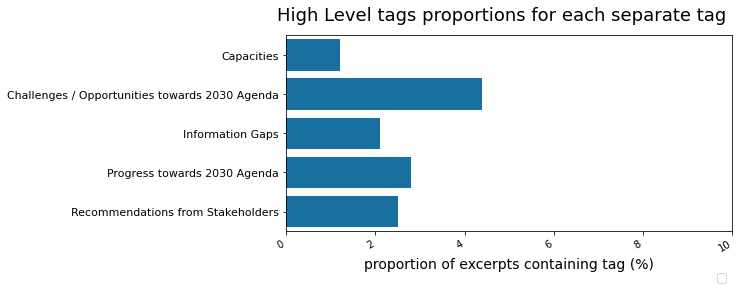

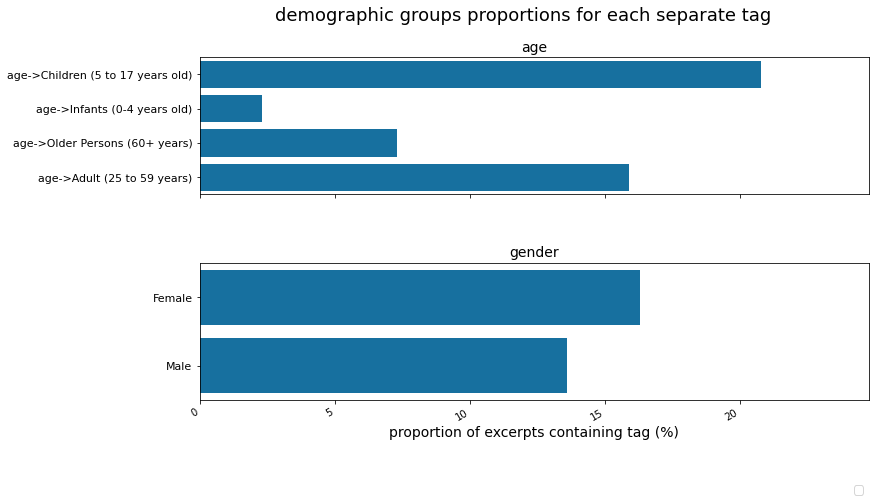

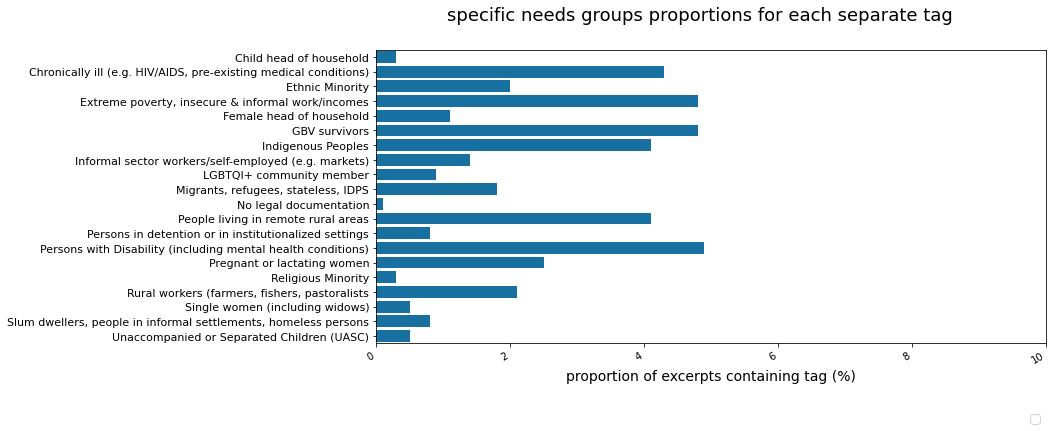

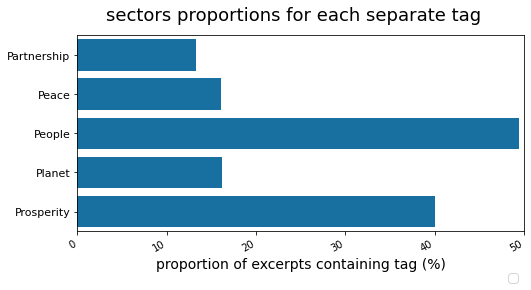

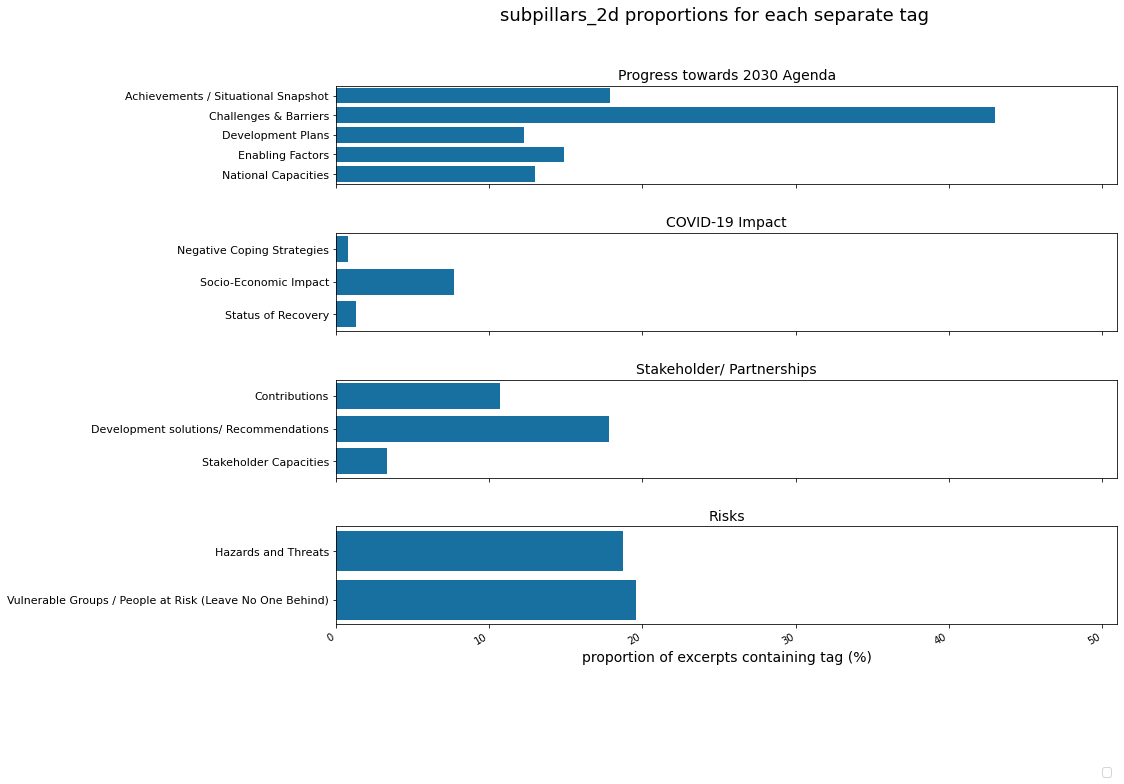

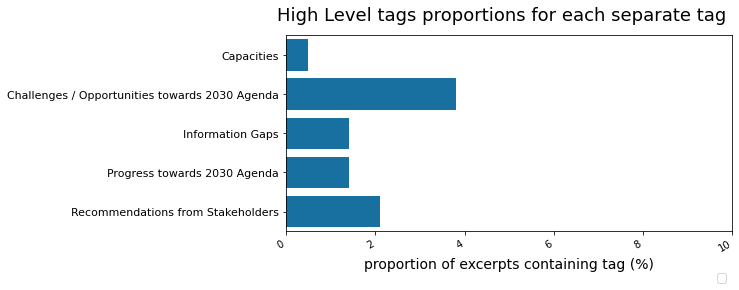

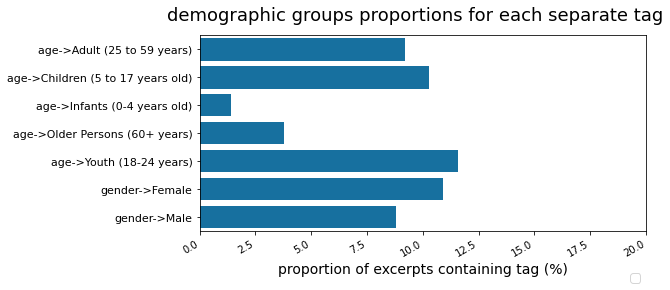

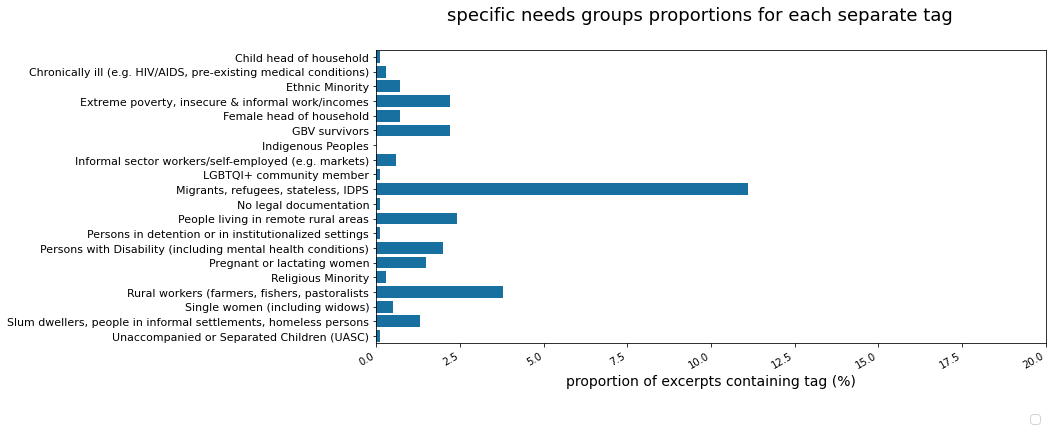

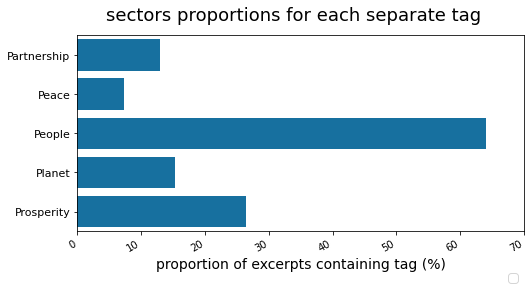

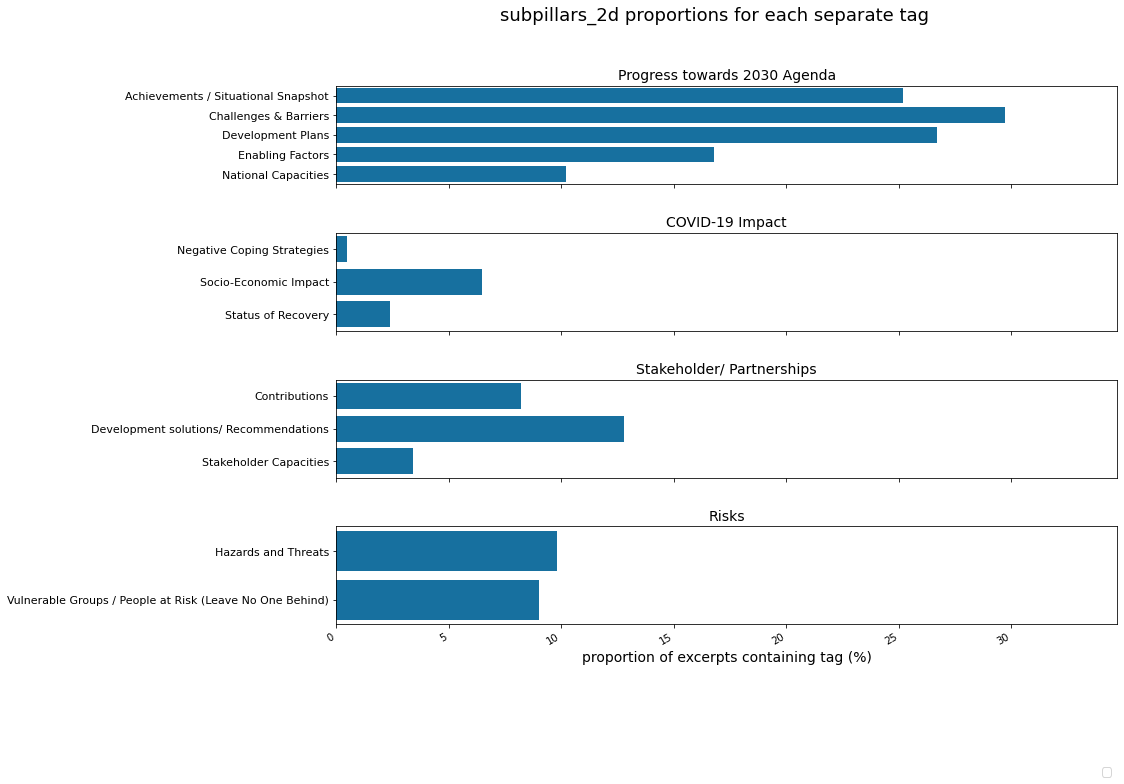

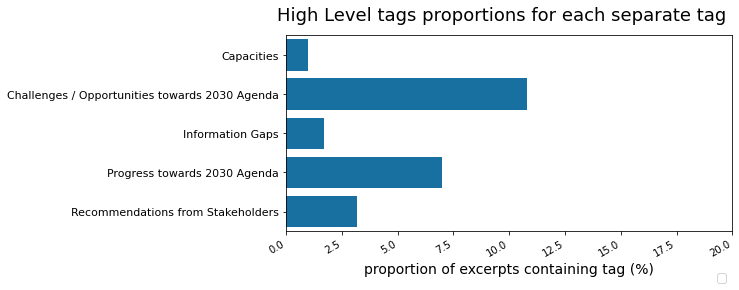

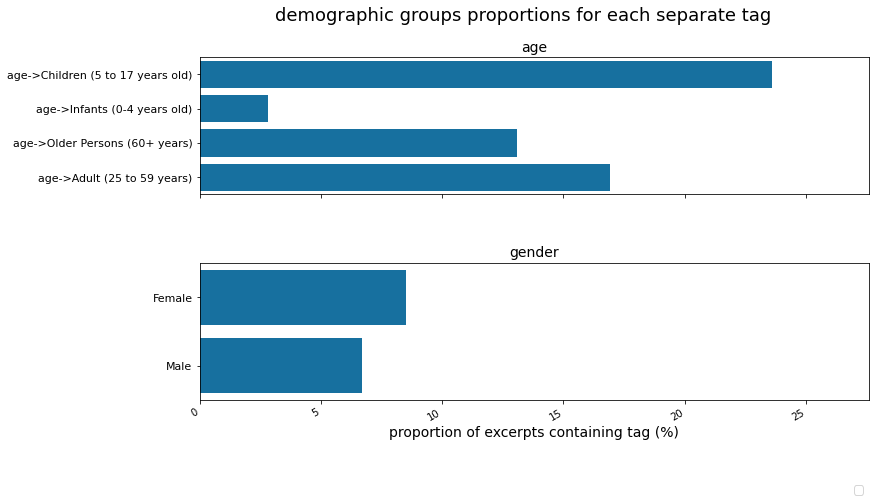

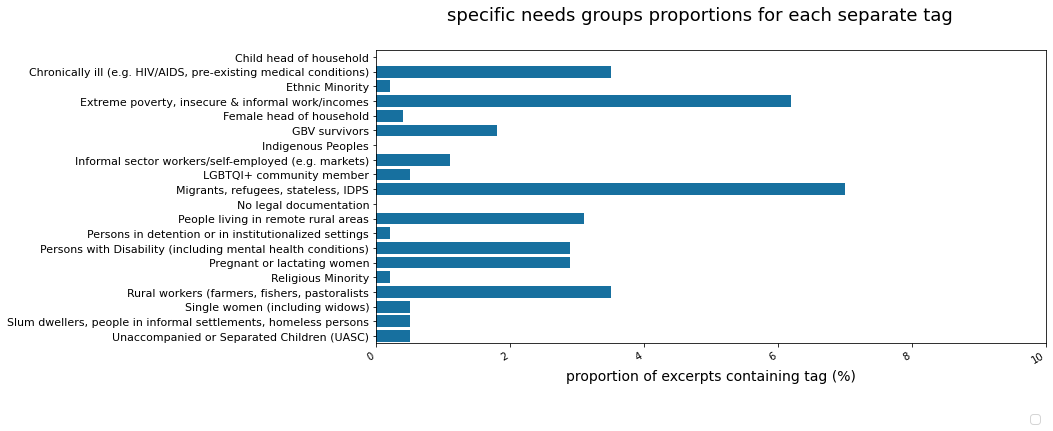

In [28]:
for one_project, df_one_project in data_as_dict.items():
    dir_one_proj = os.path.join('UNDCO data', 'vizu', one_project)
    if not os.path.exists(dir_one_proj):
        os.makedirs(dir_one_proj)
    for col_name in treated_columns:
        get_barplots(df_one_project[col_name], col_name, os.path.join(dir_one_proj, f"{col_name.replace('/', ',')}.png"))

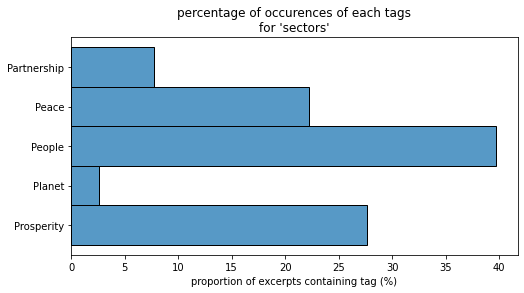

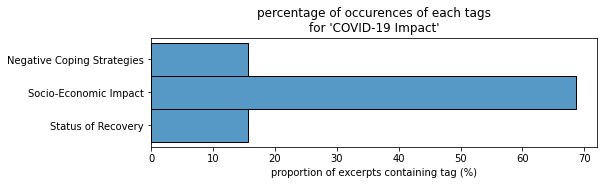

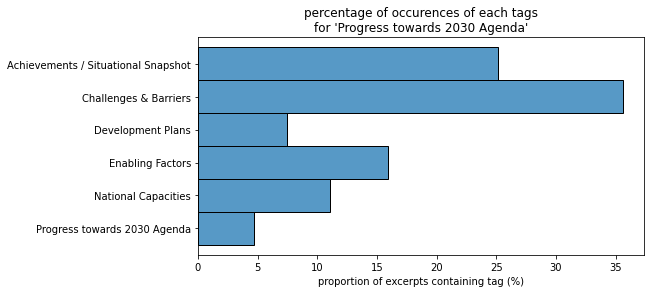

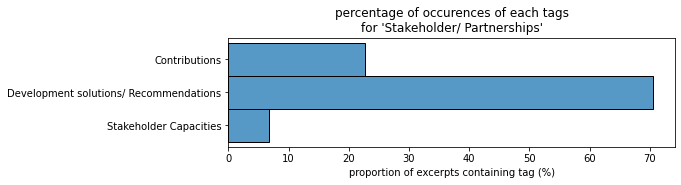

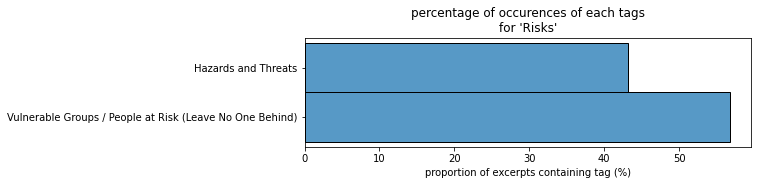

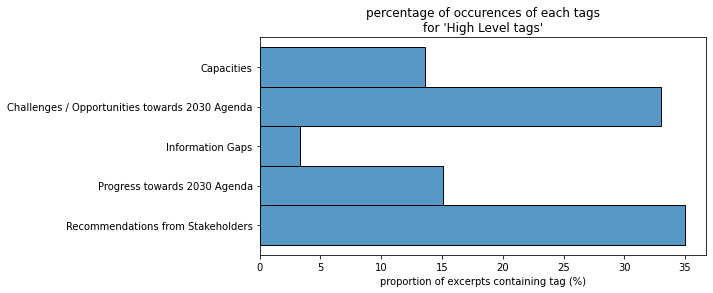

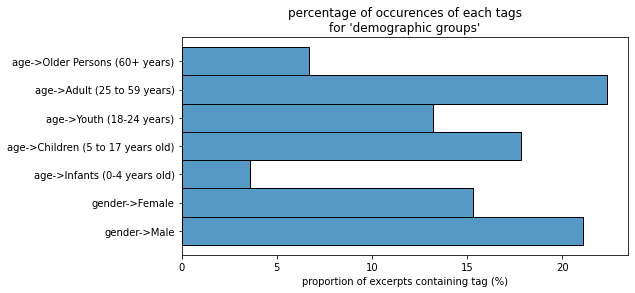

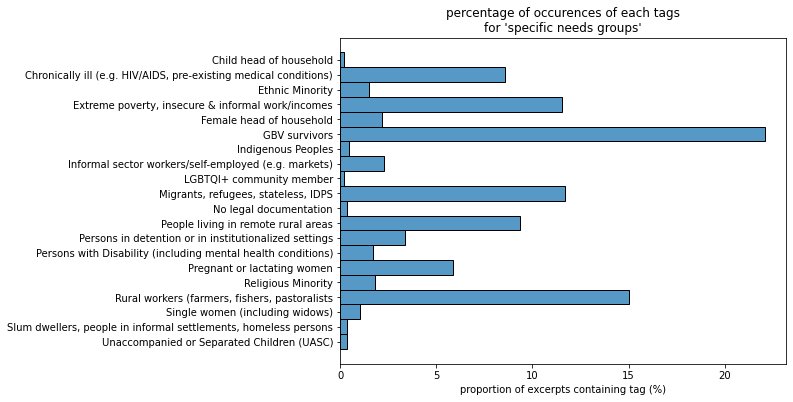

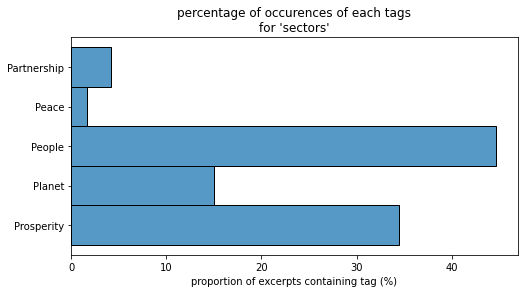

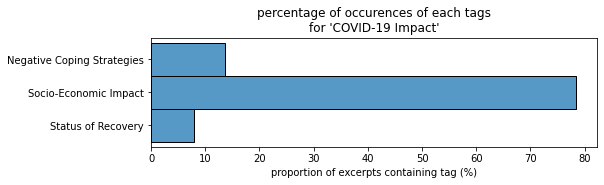

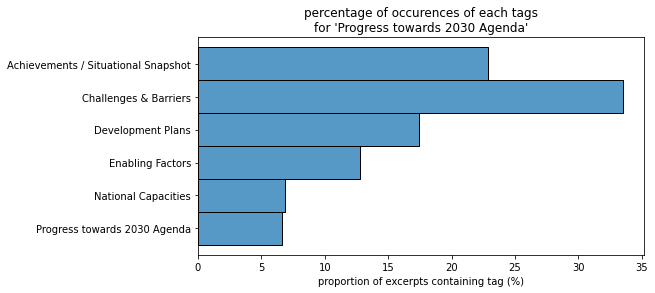

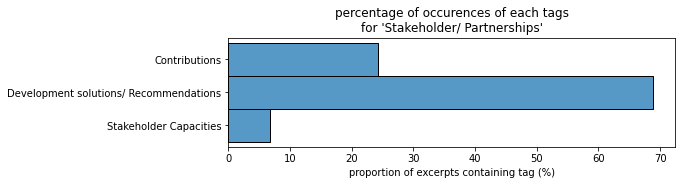

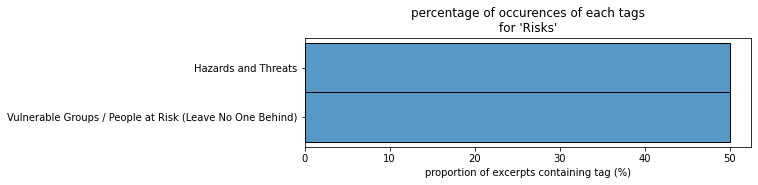

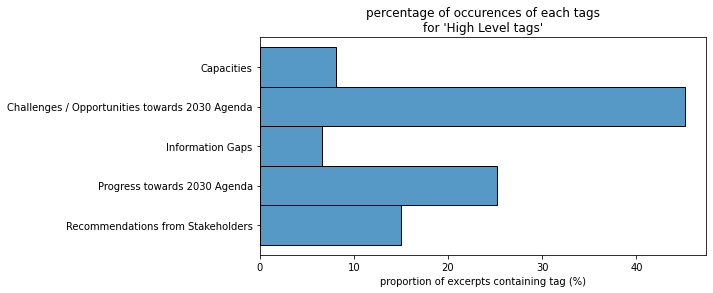

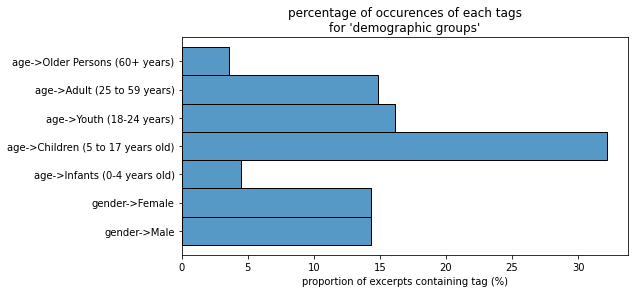

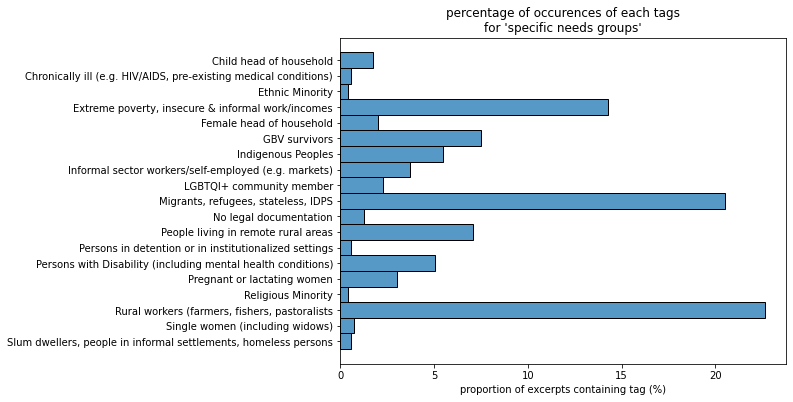

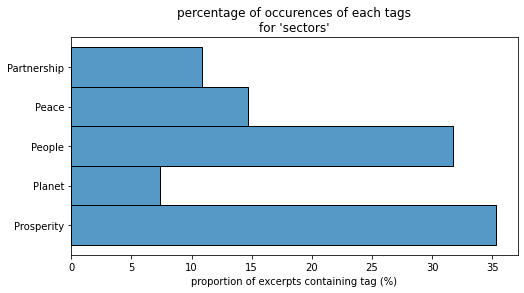

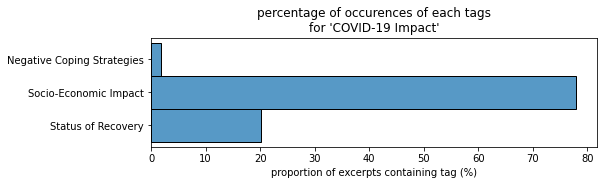

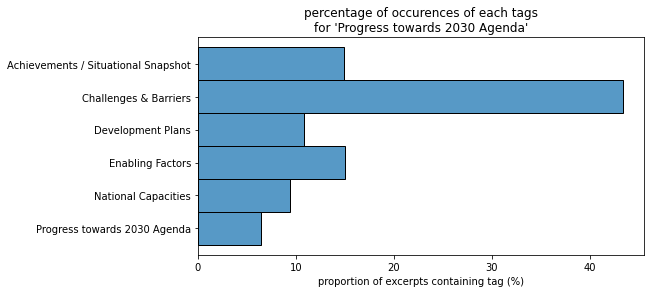

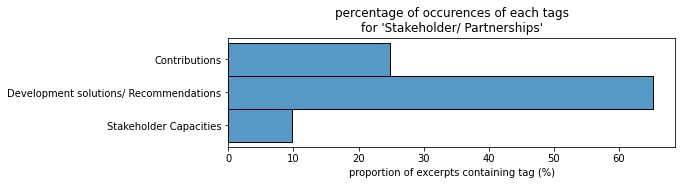

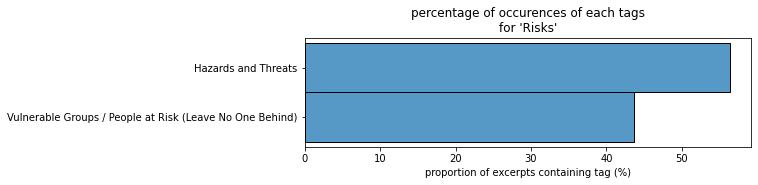

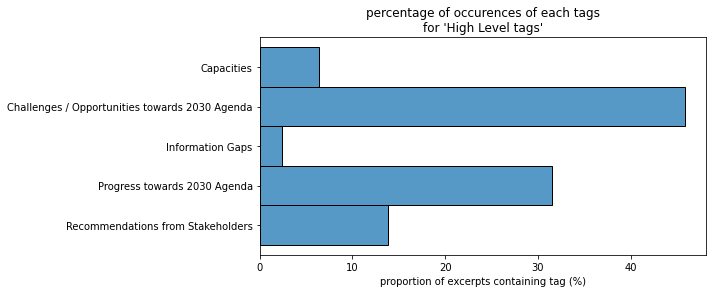

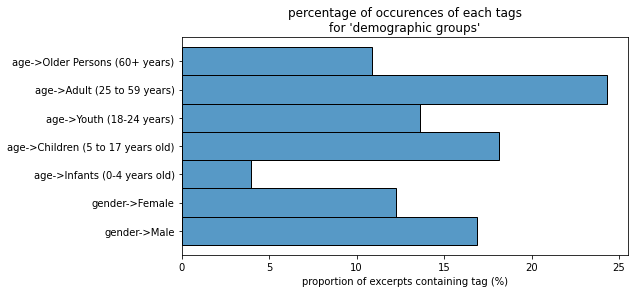

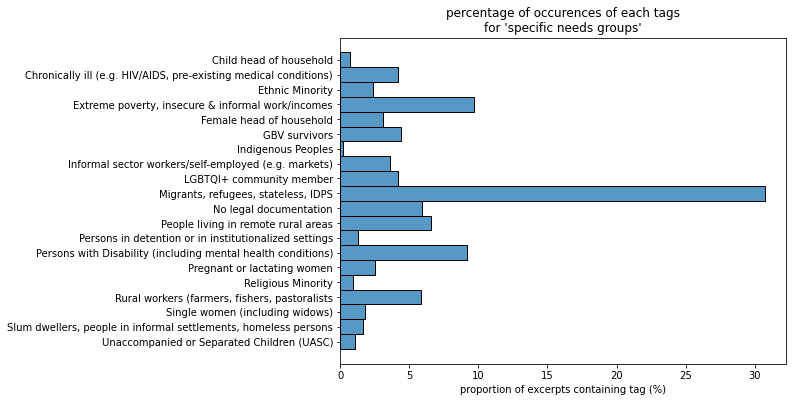

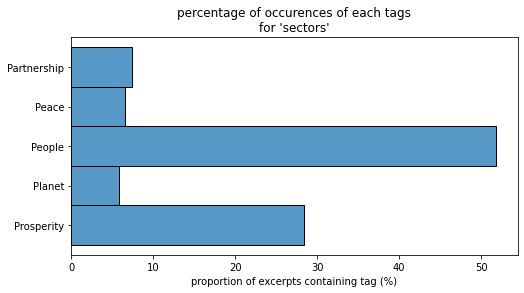

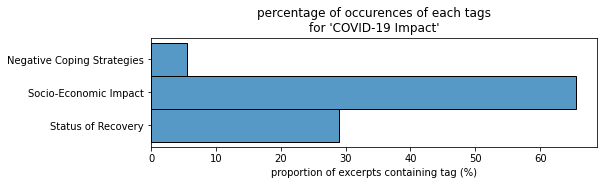

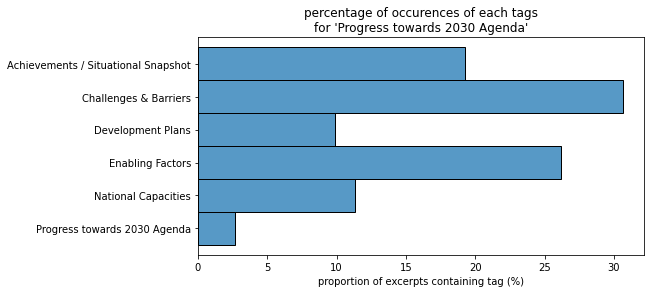

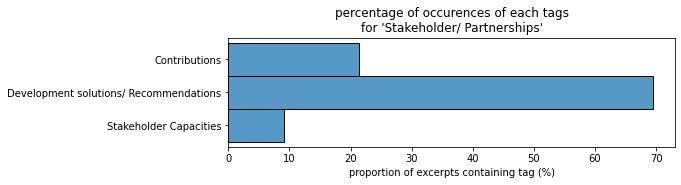

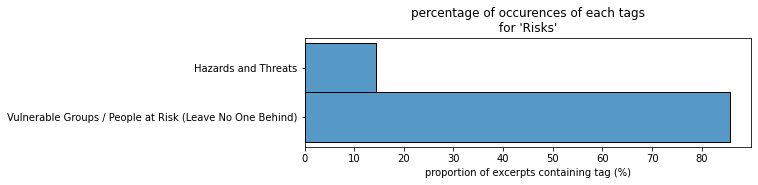

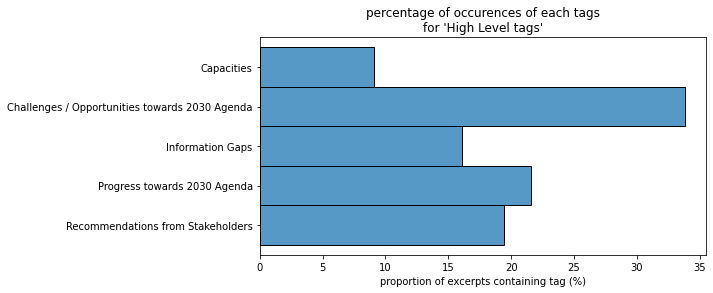

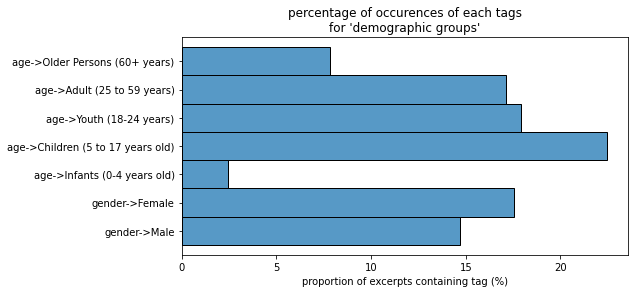

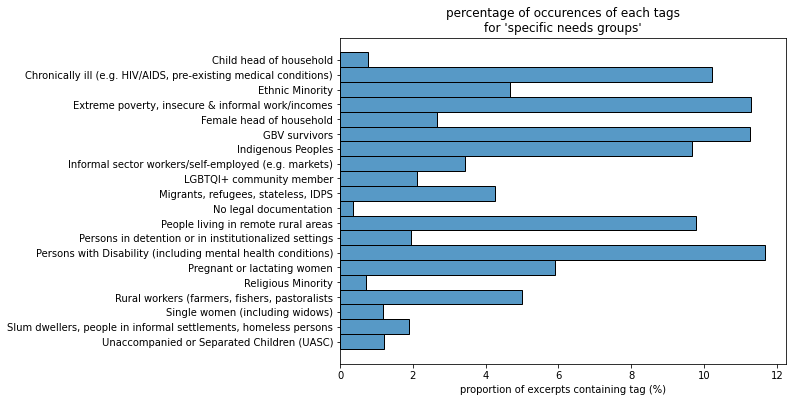

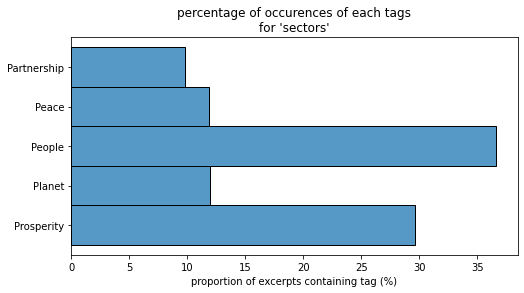

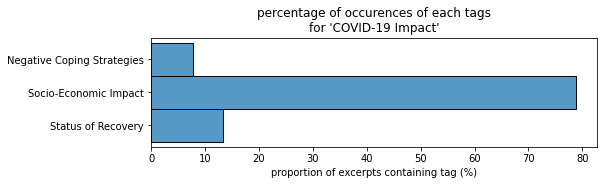

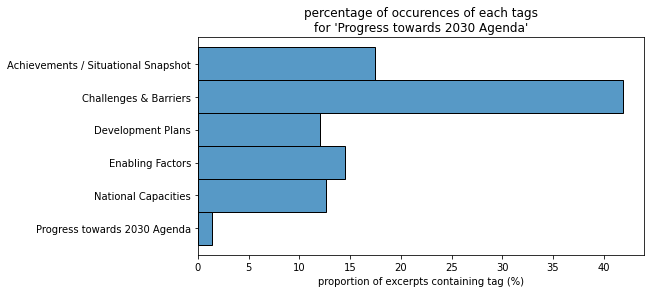

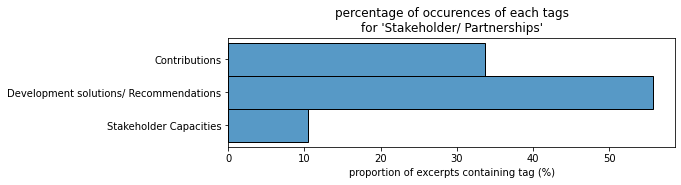

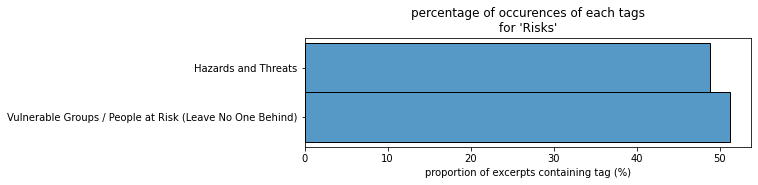

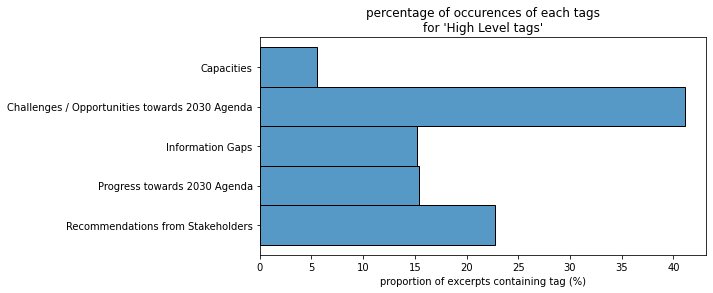

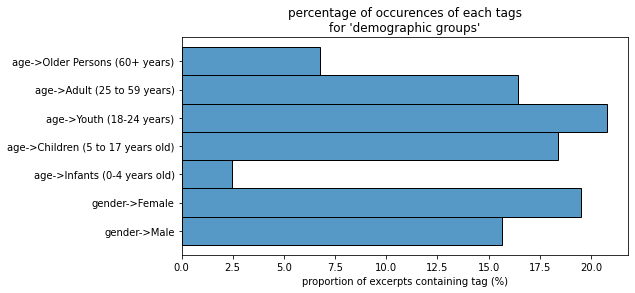

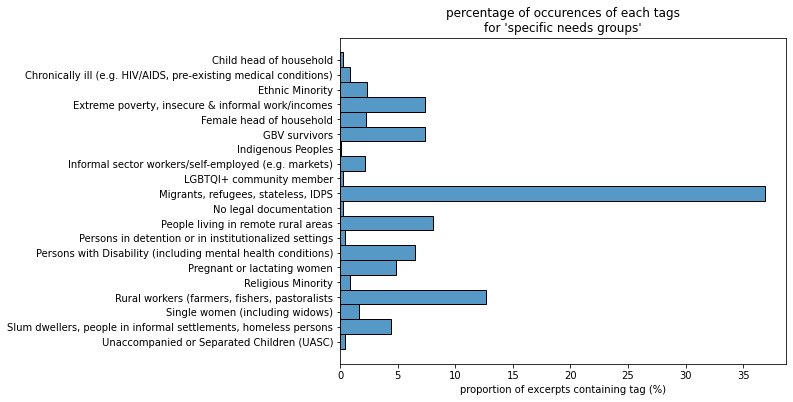

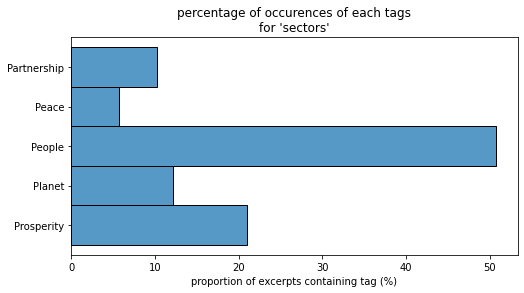

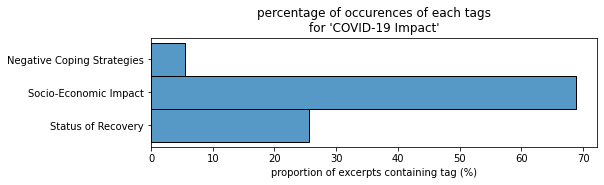

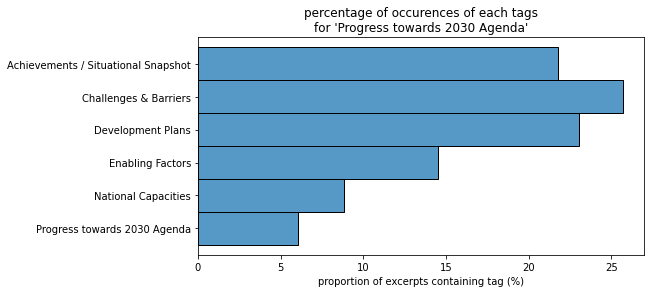

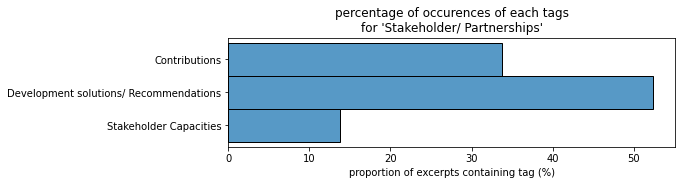

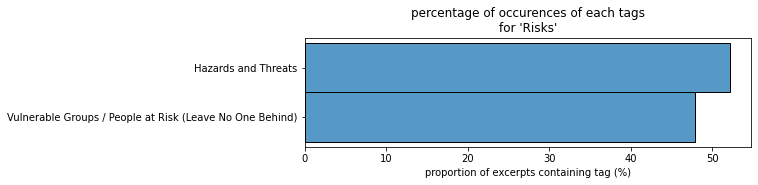

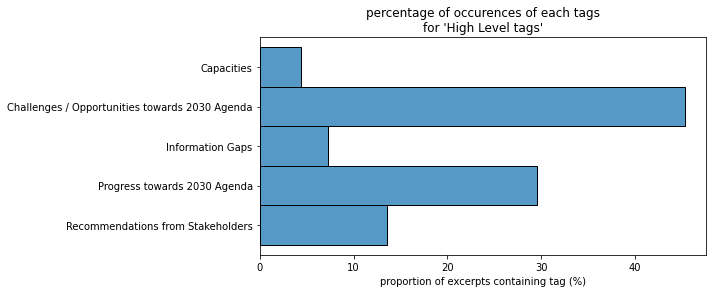

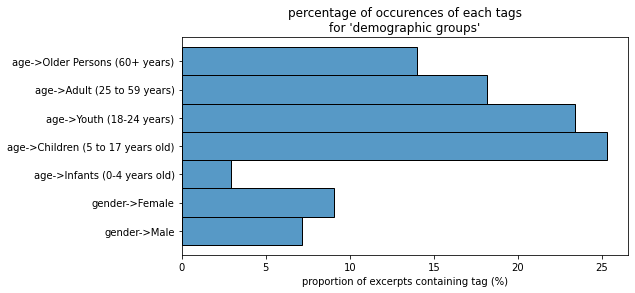

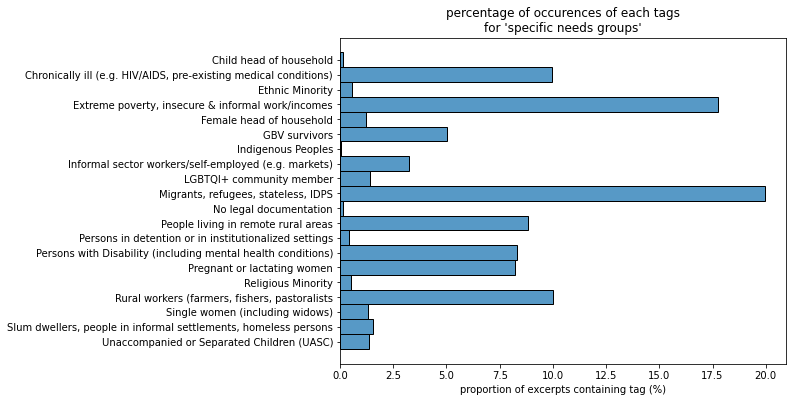

## Generate Report

In [32]:
from ast import literal_eval
import pandas as pd

from utils import update_outputs_list, omit_punctuation, order_dict

In [29]:
with open("UNDCO data/full_report_CAR.json") as f:
    generated_data = f.read()

generated_data = literal_eval(generated_data)

sorted_treated_columns = [
    "sectors",
    "COVID-19 Impact",
    "Progress towards 2030 Agenda",
    "Stakeholder/ Partnerships",
    "Risks",
    "High Level tags",
    "demographic groups",
    "specific needs groups",
]

generated_data = {
    subsection_name: generated_data[subsection_name]
    for subsection_name in sorted_treated_columns
}


In [33]:
final_report = ""
final_raw_outputs = ""

used_entries_df = pd.DataFrame()

final_report, final_raw_outputs = update_outputs_list(
    final_report, final_raw_outputs, str(r"\newpage")
)

final_report, final_raw_outputs = update_outputs_list(
    final_report, final_raw_outputs, str("\n \section{Summaries}\n")
)

for (
    subsection_name,
    generated_data_one_subsection,
) in generated_data.items():
    final_report, final_raw_outputs = update_outputs_list(
        final_report,
        final_raw_outputs,
        str("\subsection{" + subsection_name + "}\n"),
    )

    for tag, generated_entries_one_tag in order_dict(
        generated_data_one_subsection
    ).items():

        final_report, final_raw_outputs = update_outputs_list(
            final_report,
            final_raw_outputs,
            str("\paragraph{" + omit_punctuation(tag) + "}\n"),
        )

        try:
            clean_generated_entries_one_tag = literal_eval(
                generated_entries_one_tag
            )
        except Exception as e:
            clean_generated_entries_one_tag = generated_entries_one_tag
            
        final_report, final_raw_outputs = update_outputs_list(
            final_report, final_raw_outputs, clean_generated_entries_one_tag
        )

        #paragraph_df = update_df(generated_entries_one_tag)
        #paragraph_df["paragraph"] = f"{subsection_name}->{tag}"
        #one_period_df = one_period_df.append(paragraph_df)

        # final_str += clean_characters(v)
        final_report, final_raw_outputs = update_outputs_list(
            final_report, final_raw_outputs, "\n \n"
        )

final_report = (
    final_report.replace("_", " ")
    .replace("june", "June")
    .replace("july", "July")
    .replace("subpillars 1d", "Operational Environment")
    .replace("subpillars 2d", "2D Pillars")
    .replace("subsectors", "Subsectors")
    .replace("affected groups", "Affected Groups")
    .replace('%', '\%')
    .replace('\\%', '\%')
    .replace('\\\%', '\%')
    .replace('\\$', '\$')
)


In [34]:
print(final_report)

\newpage
 \section{Summaries}
\subsection{sectors}
\paragraph{Partnership}
 Public-private partnership: certain priority actions of the various strategies of the country in terms of fighting poverty clearly had: "That the resources are managed in a sustainable way," said the Minister of the Interior. French cooperation has effectively contributed to the formulation of the strategy to redeploy the territorial administration at the end of 2014, to the implementation of the national coordination mechanisms for the redeployment of public administration.
 
\paragraph{Planet}
 The energy sector has become the 3rd largest CO2 producer behind the agricultural and forestry sectors with 2\% of emissions per year, up to almost 25\% of the total of the greenhouse gas emissions of the country by 2030. In the Central African Republic, the prefectures most affected by land degradation are those of Nana-Gribizi (where negative ecological change is high) and Kémo and Ouham Pendé.
 
\subsection{COVID-19